# MNIST Digit Classification

Using standard out of box methods for machine learning one can achieve high levels of acccuracy for reading handwritten characters. Stochastic gradient descent and random forest classifiers are used while tuning the hyperparameters to achieve a very high level of accuracy.

# Data Preparation

Scikit-learn has its own repository of standard datasets that can be used to practice its machine learning capabilities. In particular the MNIST is the most iconic dataset containing 70,000 instances of 28x28 handwritten digits and is the textbook dataset for any beginner machine learning practitioner

In [2]:
from sklearn.datasets import fetch_mldata
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

mnist = fetch_mldata('MNIST Original')
X, y = mnist["data"], mnist["target"]
print(X.shape,y.shape)

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

(70000, 784) (70000,)


Data is represented as a 784 dimension vector but is really a 28x28 pixel image. The intensity varies from 0 to 255 which is the grayscale value. We can recover this representation by reshaping the vector using numpy and matplotlibs imshow method.

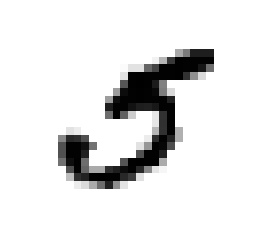

In [2]:
some_digit = X[36000]

def plot_digit(digit):
    digit = digit.reshape(28,28)
    plt.imshow(digit, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()
    
plot_digit(some_digit)

In [3]:
y[36000]

5.0

We split the dataset into the train and test sets. Fortunately the MNIST dataset is pre-loaded in a nice order that allows for easy splitting without requiring additional stratification. However we must shuffle the indices of the training dataset to ensure that labelled examples are not listed consecutively by digit, as this can cause issues with the learning.

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

We can reduce the problem into the binary classification of digits that are 5 or not 5. It is a simple case of fitting the SGD classifier on this dataset. Individual records or more can be predicted using the classifier's predict method.

In [4]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

NameError: name 'some_digit' is not defined

To ensure optimal generalization to the test set and new instances of data, we implement cross validation to carve up the data into folds for separate fitting and evaluation. The resulting output is the resulting score of each fold (in this case we care about accuracy).

In [5]:
from sklearn.model_selection import cross_val_score

cross_val = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
cross_val

array([ 0.95785,  0.9527 ,  0.9649 ])

The base cross validation method provided by scikit-learn is simple to use but does not always have what one needs. One can implement their own with StratifiedKFold. The accuracy achieved by the model is above 90%.

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    accuracy = sum(y_pred == y_test_folds) / len(y_pred)

90% would seem pretty good for an initial start despite by no means being anywhere near as accurate as a human. There are problems with using this metric. How about if we create a classifier that always predicts not digit 5.

In [8]:
from sklearn.base import BaseEstimator

class Never5Class(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [9]:
n5class = Never5Class()
cross_val_never5 = cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring="accuracy")
cross_val_never5

array([ 0.96605,  0.96735,  0.965  ])

In [10]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

The confusion matrix represents all possible permutations of predicted and actual classes, which gives additional information as to what aspects of one's predictions are correct.

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53839,   740],
       [ 1292,  4129]], dtype=int64)

In [12]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

We can capture these nuances through the addition of two metrics, precision and recall. Intuitively, precision is how often you are correct when you flag an instance as being a 5, whereas recall measures your ability to capture all instances of a 5 in the dataset.

In [13]:
from sklearn.metrics import recall_score, precision_score
print(recall_score(y_train_5, y_train_pred))
print(precision_score(y_train_5, y_train_pred))

0.761667589006
0.848018073526


Precision and recall can be mutually exclusive, where trying to improve the value is offset by a decrease in the other. The F1 score is the harmonic mean of these two values and is sometimes used as a single metric.

In [14]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.80252672497570465

In [15]:
y_scores = sgd_clf.decision_function([some_digit])
threshold = 300000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, method="decision_function", cv=3)

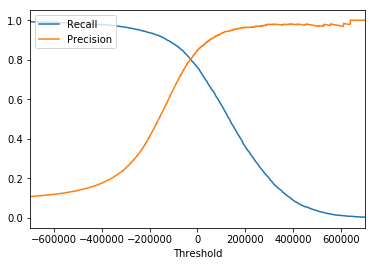

In [17]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precision, recall, threshold):
    plt.plot(threshold, recall[:-1],label = 'Recall')
    plt.plot(threshold, precision[:-1], label='Precision')
    plt.xlim(-700000,700000)
    plt.legend(loc="upper left")
    plt.xlabel("Threshold")
    plt.show()
    
plot_precision_recall_vs_threshold(precision, recall, threshold)

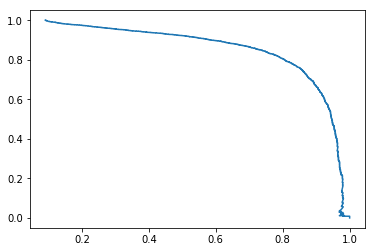

In [18]:
plt.plot(precision, recall)
plt.show()

In [19]:
y_train_pred_90 = (y_scores > 70000)
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.848018073526
0.761667589006


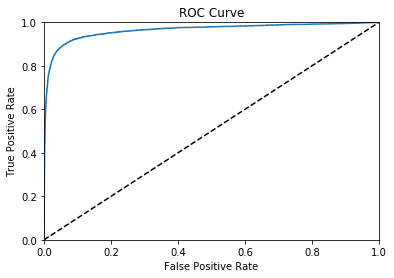

In [20]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc(fpr, tpr, label= None):
    plt.plot(fpr, tpr, label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.axis([0,1,0,1])
    plt.show()
    
plot_roc(fpr, tpr)

In [21]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train_5, y_scores))

0.964040390079


In [9]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = cross_val_predict(RandomForestClassifier(), X_train, y_train_5, cv=3, method="predict_proba")
forest_clf

NameError: name 'cross_val_predict' is not defined

In [23]:
y_scores_forest = forest_clf[:, 1]
fpr_forest, tpr_forest, threshold = roc_curve(y_train_5, y_scores_forest)

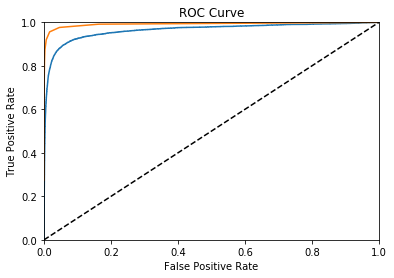

In [24]:
plt.plot(fpr, tpr, label="SGD")
plot_roc(fpr_forest, tpr_forest, "Stochastic Gradient Descent")
plt.show()

In [25]:
print(roc_auc_score(y_train_5, y_scores_forest))
print(recall_score(y_train_5, (y_scores_forest > 0.5)))
print(precision_score(y_train_5, (y_scores_forest > 0.5)))

0.992092288226
0.820512820513
0.984506418769


In [26]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [27]:
predict = sgd_clf.decision_function([some_digit])

In [28]:
np.argmax(predict)

5

In [29]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [31]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_predict = ovo_clf.predict(X_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [32]:
len(ovo_clf.estimators_)

45

In [34]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
print(forest_clf.predict([some_digit]))
print(forest_clf.predict_proba([some_digit]))

[ 5.]
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]


In [35]:
sgd_cross_score = cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")
sgd_cross_score

array([ 0.8619776 ,  0.86974349,  0.86027904])

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
sgd_cross_score_scaled = cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring="accuracy")

sgd_cross_score_scaled

array([ 0.90871826,  0.90899545,  0.91113667])

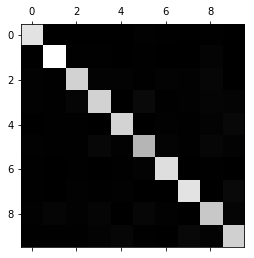

In [37]:
sgd_cross_predict = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, sgd_cross_predict)

plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

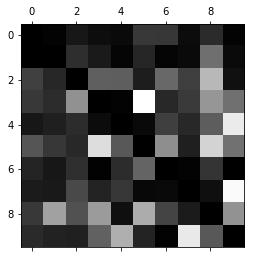

In [38]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

In [41]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [42]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv = 3)
#f1_score(y_train, y_train_knn_pred, average="macro")

In [43]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


In [44]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

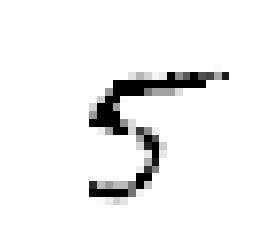

In [45]:
some_index = 5500
clean_digit = knn_clf.predict(X_test_mod[some_index].reshape(1, -1))
plot_digit(clean_digit)

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'weights': ['uniform','distance'], 
#               'n_neighbors': [3,4,5]}

# grid_search = GridSearchCV(knn_clf, param_grid = param_grid,  cv=5, verbose=3)

# grid_search.fit(X_train, y_train)
# print(grid_search.cv_results_)

In [6]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [7]:
from scipy.ndimage.interpolation import shift
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1,0), (0,1), (-1,0), (0,-1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

In [10]:
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_augmented, y_train_augmented)

NameError: name 'X_train_augments' is not defined

In [11]:
predictions = random_forest.predict(X_train_augmented)
print(sum(predictions == y_train_augmented) / len(predictions))

0.999346666667
